# 梯度加权类激活热图（Grad-CAM）

作者：[FutureSI](https://github.com/ctkindle)

日期：2021/03/12

## Grad-CAM介绍
Grad-CAM（Gradient-weighted Class Activation Mapping）即梯度加权的类别激活图，能够帮助模型开发者定位模型在训练/预测图片上对某一类别标签的激活热区，从而提供模型预测的可解释性依据。Grad-CAM 方法通过目标类别在模型最后一个卷积层上的梯度，对最后一个卷积层的全类别激活热图进行加权，从而得到模型在训练/预测图片上对目标类别进行推断的敏感区域的分布，并用“热图”的形式进行展示。其中，最后一个卷积层的全类别激活热图，通过累加该卷积层各个通道的权重得到。Grad-Cam 使用目标类别的梯度，代替了他的前身 CAM 方法中的GAP（Global Average Pooling 全局平均池化）提供的类别加权，所以不需要模型中必须含有 GAP 层，具有更广的模型结构适用范围。

![](https://ai-studio-static-online.cdn.bcebos.com/619d19a1402348a186dde7735c54dc023417bade66cf48c799194213106d30e0)

* 论文原文：[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
* 论文原版代码：[https://github.com/ramprs/grad-cam/](https://github.com/ramprs/grad-cam/)

## 解压数据集
从 CalTech101 数据集抽取了其中的16类组成一个子数据集。

In [1]:
# 数据集处理
!unzip -qa -o -d /home/aistudio/data/data22612/ /home/aistudio/data/data22612/Images.zip
%cd /home/aistudio/data/data22612/
import os
import numpy as np

# 获得当前路径
path = os.getcwd()
# 改变训练集文件列表的分隔符
file_list = np.loadtxt(path+'/Train.txt', dtype='str')
np.savetxt(path+'/Train.txt', file_list, fmt='%s', delimiter=" ")
# 改变验证集文件列表的分隔符
file_list = np.loadtxt(path+'/Eval.txt', dtype='str')
np.savetxt(path+'/Eval.txt', file_list, fmt='%s', delimiter=" ")
%cd /home/aistudio/

/home/aistudio/data/data22612
/home/aistudio


## 框架导入、参数设置

In [9]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset, DataLoader, IterableDataset
import numpy as np
import cv2
import random
import time
from PIL import Image
from paddle.vision.transforms import RandomCrop, CenterCrop, Resize, ColorJitter, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
import os
from paddle import ParamAttr
import paddle.nn.functional as F
from paddle.nn import Conv2D, BatchNorm, Linear, Dropout, ReLU
from paddle.nn import AdaptiveAvgPool2D, MaxPool2D, AvgPool2D
from paddle.nn.initializer import Uniform
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings("ignore", category=Warning) # 过滤报警信息

BATCH_SIZE = 32
DATA_DIR = '/home/aistudio/data/data22612/' # 设置训练集数据地址
PIC_SIZE = 224
EPOCH_NUM = 400
CLASS_DIM = 102
PLACE = paddle.CUDAPlace(0)  # 在gpu上训练


## 训练数据处理包括归一化、数据增强

In [10]:
class HideAndSeek(object):
    def __init__(self):
        # possible grid size, 0 means no hiding
        self.grid_sizes = [0, 16, 32, 44, 56]
        # hiding probability
        self.hide_prob = 0.3

    def __call__(self, img):
        # randomly choose one grid size
        grid_size = np.random.choice(self.grid_sizes)

        h, w, _ = img.shape

        # hide the patches
        if grid_size == 0:
            return img
        for x in range(0, w, grid_size):
            for y in range(0, h, grid_size):
                x_end = min(w, x + grid_size)
                y_end = min(h, y + grid_size)
                if (random.random() <= self.hide_prob):
                    img[x:x_end, y:y_end, :] = 0

        return img

# 处理图片数据：随机裁切、调整图片数据形状、归一化数据
def data_transform(img, output_size, channel_first=True, mode='train'):
    # random crop
    if mode == 'train':
        rs = Resize((output_size + 32))
    else:
        rs = Resize((output_size, output_size))

    cj = ColorJitter(0.4, 0.4, 0.4, 0.4)
    rhf = RandomHorizontalFlip()
    rvf = RandomVerticalFlip()
    rr = RandomRotation(random.randint(0, 360))
    hs = HideAndSeek()

    img = rs(img)
    if mode == 'train':
        rc = RandomCrop(output_size, pad_if_needed=True)
        img = rc(img)

        # augmentation
        img = cj(img)
        img = rhf(img)
        img = rvf(img)
        img = rr(img)
        img = hs(img)
    else:
        cc = CenterCrop(output_size)
        img = cc(img)
    # normalize
    img = img / 255. * 2. - 1.
    # from [H,W,C] to [C,H,W]
    if channel_first == True:
        img = np.transpose(img, (2, 0, 1))
    # data type
    img = img.astype('float32')    
    return img

# 定义数据集对象
class CaltechDateset(Dataset):
    def __init__(self, data_dir, mode='valid'):
        super(CaltechDateset, self).__init__()
        self.mode = mode
        self.data_dir = data_dir
        self.data_list = []
        if mode == 'train':
            self.data_list = np.loadtxt(self.data_dir+'Train.txt', dtype='str')
        elif mode == 'valid':
            self.data_list = np.loadtxt(self.data_dir+'Eval.txt', dtype='str')
        self.data_list_length = self.data_list.shape[0]
    def __getitem__(self, idx):
        img_dir = self.data_dir+'Images/'+self.data_list[idx][0]
        img = cv2.imread(img_dir)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = data_transform(img, PIC_SIZE, mode=self.mode)
        return img, int(self.data_list[idx][1])
    def __len__(self):
        return self.data_list_length

# 定义图片loader

trn_ctdateset = CaltechDateset(DATA_DIR, 'train')
train_loader = DataLoader(trn_ctdateset, places=PLACE, shuffle=True, batch_size=BATCH_SIZE, drop_last=False, num_workers=0, use_shared_memory=False)
val_ctdateset = CaltechDateset(DATA_DIR, 'valid')
valid_loader = DataLoader(val_ctdateset, places=PLACE, shuffle=False, batch_size=BATCH_SIZE, drop_last=False, num_workers=0, use_shared_memory=False)


## 辅助函数定义、读取用于测试 Grad-CAM 的数据

读取的数据形状： [32, 3, 224, 224] [32]


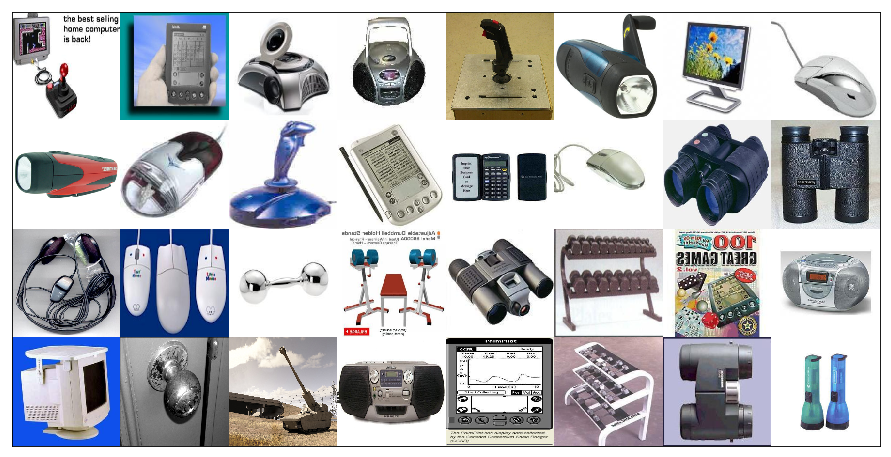

In [11]:
def save_show_pics(pics, file_name='tmp', save_path='./output/pics/', save_root_path='./output/', figsize=None):
    if not os.path.exists(save_root_path):
        os.makedirs(save_root_path)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    shape = pics.shape
    pic = pics.transpose((0,2,3,1)).reshape([-1,8,PIC_SIZE,PIC_SIZE,3])
    pic = np.concatenate(tuple(pic), axis=1)
    pic = np.concatenate(tuple(pic), axis=1)
    pic = (pic + 1.) / 2.
    plt.imsave(save_path+file_name+'.jpg', pic)

    if figsize != None:
        plt.figure(figsize=figsize, dpi=80)
    plt.imshow(pic)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# 存储测试 Grad-Cam 的图片
ctdateset = CaltechDateset(DATA_DIR, 'valid')
loader = DataLoader(ctdateset, places=PLACE, shuffle=True, batch_size=BATCH_SIZE, drop_last=True, num_workers=0, use_shared_memory=False)
data, label = next(loader())
print("读取的数据形状：", data.shape, label.shape)
save_show_pics(data.numpy(), figsize=(14, 14), file_name='orginal')

## 定义模型并测试前向计算输出
训练模式下forward()方法返回模型前向计算的结果；验证模式下除前向计算结果还同时返回最后一个卷积层的权重用于计算 Grad-CAM。

In [17]:
class BnActConv(nn.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 filter_size,
                 stride=1):
        super(BnActConv, self).__init__()

        self._batch_norm = BatchNorm(num_channels)
        self._act = ReLU()
        self._conv = Conv2D(
            in_channels=num_channels,
            out_channels=num_filters,
            kernel_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            bias_attr=False)

    def forward(self, inputs):
        y = self._batch_norm(inputs)
        y = self._act(y)
        y = self._conv(y)
        return y

class ResBlockV2(nn.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 stride,
                 shortcut=True):
        super(ResBlockV2, self).__init__()
        self.stride = stride
        self.conv0 = BnActConv(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=3,
            stride=stride)
        self.conv1 = BnActConv(
            num_channels=num_filters,
            num_filters=num_filters,
            filter_size=3)

        self.short = BnActConv(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=1,
            stride=stride)

        self.shortcut = shortcut

    def forward(self, inputs):
        y = self.conv0(inputs)
        conv1 = self.conv1(y)

        if self.shortcut:
            short = self.short(inputs)
        else:
            short = inputs
        y = paddle.add(x=short, y=conv1)
        return y

class EmbeddedGaussion(nn.Layer):
    def __init__(self, shape):
        super(EmbeddedGaussion, self).__init__()

        input_dim = shape[1]

        self.theta = nn.Conv2D(input_dim, input_dim // 2, 1)
        self.phi = nn.Conv2D(input_dim, input_dim // 2, 1)
        self.g = nn.Conv2D(input_dim, input_dim // 2, 1)

        self.conv = nn.Conv2D(input_dim // 2, input_dim, 1)
        self.bn = nn.BatchNorm2D(input_dim, weight_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(0)))

    def forward(self, x):
        shape = x.shape

        theta = paddle.flatten(self.theta(x), start_axis=2, stop_axis=-1)
        phi = paddle.flatten(self.phi(x), start_axis=2, stop_axis=-1)
        g = paddle.flatten(self.g(x), start_axis=2, stop_axis=-1)

        non_local = paddle.matmul(theta, phi, transpose_y=True)
        non_local = nn.functional.softmax(non_local)
        non_local = paddle.matmul(non_local, g)
        non_local = paddle.reshape(non_local, [shape[0], shape[1] // 2, shape[2], shape[3]])
        non_local = self.bn(self.conv(non_local))

        return non_local + x

class UseResidualBlockV2(nn.Layer):
    def __init__(self, num_classes=16, input_dim=3, ngf=64):
        super(UseResidualBlockV2, self).__init__()
        model_1 = [
            nn.Conv2D(input_dim, ngf, 7, 2, 3),

            ResBlockV2(ngf, ngf * 2, 2),
            ResBlockV2(ngf * 2, ngf * 2, 1, shortcut=False),
            ResBlockV2(ngf * 2, ngf * 2, 1, shortcut=False),
            ResBlockV2(ngf * 2, ngf * 2, 1, shortcut=False),

            ResBlockV2(ngf * 2, ngf * 2 ** 2, 2),
            ResBlockV2(ngf * 2 ** 2, ngf * 2 ** 2, 1, shortcut=False),
            ResBlockV2(ngf * 2 ** 2, ngf * 2 ** 2, 1, shortcut=False),
            ResBlockV2(ngf * 2 ** 2, ngf * 2 ** 2, 1, shortcut=False),

            ResBlockV2(ngf * 2 ** 2, ngf * 2 ** 3, 2),
            ResBlockV2(ngf * 2 ** 3, ngf * 2 ** 3, 1, shortcut=False),
            ResBlockV2(ngf * 2 ** 3, ngf * 2 ** 3, 1, shortcut=False),
            ResBlockV2(ngf * 2 ** 3, ngf * 2 ** 3, 1, shortcut=False),
            EmbeddedGaussion([BATCH_SIZE, ngf * 2 ** 3, 14, 14]),

            ResBlockV2(ngf * 2 ** 3, ngf * 2 ** 4, 2),
            ResBlockV2(ngf * 2 ** 4, ngf * 2 ** 4, 1, shortcut=False),
            ResBlockV2(ngf * 2 ** 4, ngf * 2 ** 4, 1, shortcut=False),
            ResBlockV2(ngf * 2 ** 4, ngf * 2 ** 4, 1, shortcut=False),
            nn.BatchNorm2D(ngf * 2 ** 4),
        ]
        model_2 = [
            nn.AdaptiveAvgPool2D(1),
            nn.Flatten(1, -1),
            nn.Linear(ngf * 2 ** 4, num_classes),
        ]
        self.model_1 = nn.Sequential(*model_1)
        self.model_2 = nn.Sequential(*model_2)

    def forward(self, x):
        conv = self.model_1(x)
        if self.training:
            return self.model_2(conv)
        else:
            return self.model_2(conv), conv

x = paddle.to_tensor(np.random.uniform(-1, 1, [BATCH_SIZE, 3, PIC_SIZE, PIC_SIZE]).astype('float32'))
urbv2 = UseResidualBlockV2()
urbv2.train()
y = urbv2(x)
print('[train]', '前向计算结果的形状:', y.shape)
urbv2.eval()
y, conv = urbv2(x)
print('[eval]', '前向计算结果的形状:', y.shape, ', 最后一个卷积层权重的形状:', conv.shape)


[train] 前向计算结果的形状: [32, 16]
[eval] 前向计算结果的形状: [32, 16] , 最后一个卷积层权重的形状: [32, 1024, 7, 7]


## 模型训练、权重保存
使用 Paddle2.0 版本 HAPI 配置、训练模型。

In [ ]:
# 模型定义
model = paddle.Model(UseResidualBlockV2(num_classes=CLASS_DIM))
# 设置训练模型所需的optimizer, loss, metric
model.prepare(
    paddle.optimizer.Adam(learning_rate=1e-4, parameters=model.parameters()),
    paddle.nn.CrossEntropyLoss(),
    paddle.metric.Accuracy(topk=(1, 5)),
    )
# 启动训练、评估
model.fit(
    train_loader,
    epochs=EPOCH_NUM,
    log_freq=50, 
    save_dir='model',
    save_freq=200,
    callbacks=paddle.callbacks.VisualDL(log_dir='./log/gradcam'),
    )


## 模型权重读取
预测试需要将模型设为验证模式，以同时返回最后一个卷积层的权重，用来计算 Grad-CAM。

In [18]:
model = UseResidualBlockV2(num_classes=CLASS_DIM)
model.set_state_dict(paddle.load('/home/aistudio/model/400.pdparams'))
model.eval()

## 生成 Grad-CAM 激活特图
生成的（已经叠加了激活热图的）图片和原图片都保存在'./output/'路径下。

In [19]:
# 提取目标类别对最后一个卷积层的梯度
def extrack_featuremap_gradient(model, img, label, class_dim=CLASS_DIM):
    predict, feature_map = model(img) # 获取模型预测输出和模型中最后一层卷积层的特征图
    predict_one_hot = paddle.nn.functional.one_hot(label, class_dim) * predict # 将模型输出转化为one-hot向量
    score = paddle.sum(predict_one_hot, axis=1) # 得到预测结果中概率最高的那个分类的值
    gradients_map = paddle.grad(score, feature_map)[0] # 计算最高分类概率score对最后一层卷积层的梯度
    gradients_map_mean = paddle.mean(gradients_map, (2, 3), keepdim=True) # 对各点的梯度求均值，将形状从[-1, c, h, w]变为[-1, c]
    return gradients_map_mean, feature_map

# 获取 Grad-CAM 类激活热图
def get_gradcam(model, img, label):
    grad_map_mean, feature_map = extrack_featuremap_gradient(model, img, label) # 得到梯度和特征图
    cam = paddle.sum(grad_map_mean * feature_map, axis=1) # 将特征图加权（平均梯度）求和
    cam = paddle.maximum(cam, paddle.to_tensor(0.)) # 进行ReLU操作，小于0的值设为0
    cam = cam / paddle.max(cam) # 归一化至[0, 1]
    return cam.numpy()

# 将 Grad-CAM 叠加在原图片上显示激活热图的效果
def show_cam(model, data, label):
    imgs = data.numpy()
    heat_maps = []
    for i in range(data.shape[0]):
        img = ((imgs[i] + 1.) / 2. * 255.).astype('uint8').transpose([1, 2, 0]) # 归一化至[0,255]区间，形状：[h,w,c]
        cam = get_gradcam(model, data[i:i + 1], label[i])
        heatmap = cv2.resize(cam[0] * 255., (imgs.shape[2], imgs.shape[3])).astype('uint8') # 调整热图尺寸与图片一致、归一化
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # 将热图转化为“伪彩热图”显示模式
        superimposed_img = cv2.addWeighted(heatmap, .3, img, .7, 1.) # 将特图叠加到原图片上
        heat_maps.append(superimposed_img)
    heat_maps = np.array(heat_maps)

    heat_maps = heat_maps.reshape([-1,8,PIC_SIZE,PIC_SIZE,3])
    heat_maps = np.concatenate(tuple(heat_maps), axis=1)
    heat_maps = np.concatenate(tuple(heat_maps), axis=1)
    cv2.imwrite('./output/pics/gradcam.jpg', heat_maps)

show_cam(model, data, label)

原图片：
![](https://ai-studio-static-online.cdn.bcebos.com/64c0fb38a4fe4701a0ec62ce175312349adfef2a27a5429a8c4ab051fdcb9c3d)

叠加 Grad-CAM 的图片：
![](https://ai-studio-static-online.cdn.bcebos.com/98577317e248471f946cc283fc179c6908769e657e5245e180117de47ae0ea67)
